In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as iio
from PIL import Image
import torch

import byotrack
from byotrack.implementation.detector.stardist import StarDistDetector
from byotrack.implementation.linker.icy_emht import IcyEMHTLinker
from byotrack.implementation.refiner.cleaner import Cleaner
from byotrack.implementation.refiner.stitching.emc2 import EMC2Stitcher
# from byotrack.implementation.refiner.interpolater import ForwardBackwardInterpolater

icy_path = "/home/noah/Documents/icy-2.4.2.0-all"
tifpath = './ExampleData/shortStack_adjusted/' #path to sequence of tiff files
#for video playback only
fps = 7

In [3]:
# Unsused or to be rewritten

#reader funtion for tif sequences - handles reshaping and normalising (using the stardist recommended normaliser) (doesn't seem to perform that well)
from csbdeep.utils import normalize as csbdeepNormaliser
    
def Read_Data_TIFseq(vid_path):
    # positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = iio.ImageCollection(vid_path + '/*.tif').concatenate() #concatonate to numpyarray
    # red_vid = iio.ImageCollection(red_vid_path + '/*.tif')
    vid = vid.reshape(vid.shape[0], vid.shape[1], vid.shape[2], 1)
    #vid = np.asarray([csbdeepNormaliser(frame) for frame in vid])
    return vid

video = Read_Data_TIFseq(tifpath)

# normalize video
mini = np.quantile(video, 0.005)
maxi = np.quantile(video, 0.999)

np.clip(video, mini, maxi, video)
video = (video - mini) / (maxi - mini)

In [4]:
# # Load TDTomato video

# video_path = "../pasteur/data/long movies_tracks/6X_red_1000_2bin.avi"

# video = byotrack.Video(video_path)

# # Test only on the 100 first frames
# video = video[:100]

# video.set_transform(byotrack.VideoTransformConfig(aggregate=True, normalize=True))

# video[0].shape, video[0].dtype, video[0].max()

In [5]:
# Visualisation of the whole video with opencv

for i, frame in enumerate(video):
    try:
        # Display the resulting frame
        cv2.imshow('Frame', frame)
        cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)}')

        # Press Q on keyboard to  exit
        key = cv2.waitKey(1000 // fps) & 0xFF

        if key == ord('q'):
            break

        if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
            break
    except Exception as e:
        print(e)
        cv2.destroyAllWindows()

# Closes all the frames
cv2.destroyAllWindows()
#warning with opencv QOBject::moveToThread can be fixed: https://stackoverflow.com/questions/52337870/python-opencv-error-current-thread-is-not-the-objects-thread

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to tar

In [6]:
#model_path = "../pasteur/stardist_test/models_15/111/stardist/32rays-pool2-0.0drop/lr0.0003-bs4"
model_path = "/home/noah/Desktop/STARDIST_CONFOCAL/NEWEST TdT MODELS/10X_IMAGES_ONLY"
detector = StarDistDetector(model_path, batch_size=1)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.592132, nms_thresh=0.3.


2023-07-15 23:36:56.052483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-15 23:36:56.052507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: NoahComp
2023-07-15 23:36:56.052509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: NoahComp
2023-07-15 23:36:56.052548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-07-15 23:36:56.052558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.116.4
2023-07-15 23:36:56.052560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.116.4 does not match DSO version 525.125.6 -- cannot find working devices in this configuration


In [7]:
# Do not run this cell in order to keep the defaults prob_thresh and nms_thresh

#TODO: add roi funtionality to this so plotting shows mask over image (better evaluation) Will need to edit both stardist detector and the detector class .detect() function to include polygon data and add imageJ ROI code
vidCopy = video[0:50] #test batch
scale = 1

global frameID
frameID = 0
frame = video[frameID]
h, w = frame.shape[0:2]
global mask_glob
detection_zero = detector.run([vidCopy[frameID]])
mask_glob = (detection_zero[frameID].segmentation.numpy() != 0).astype(np.uint8) * 255

# window_name = 'Frame', f'Frame {frameID} / {len(detections_sequence_test)} - Number of detections: {len(detections_sequence_test[i])}'
window_name = 'Paramater Test - Segmentation   (Press Q to Quit)'

try:

    #create and rescale window
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, h*scale, w*scale)

    #Frame Trackbar
    def update_frame(x): #callback function for trackbar - default argument is the position of the track bar
        detections = detector.detect(vidCopy[x][None, ...])
        global mask_glob
        mask_glob = (detections[0].segmentation.numpy() != 0).astype(np.uint8) * 255
    cv2.createTrackbar('Frame',window_name,0,len(vidCopy)-1,update_frame)

    #Probability Trackbar
    def update_probability_threshold(x):
        detector.prob_threshold = (x+1)/100 
        update_frame(frameID)
    cv2.createTrackbar('Probability Threshold', window_name, 0, 99, update_probability_threshold)

    #Overlap Trackbar
    def update_overlap_threshold(x):
        detector.nms_threshold = (x+1)/100
        update_frame(frameID)
    cv2.createTrackbar('Overlap Threshold', window_name, 0, 99, update_overlap_threshold)

except Exception as e:
    print(e)


while True:
    try:

        frameID = cv2.getTrackbarPos('Frame',window_name)
        # cv2.imshow(window_name, video[frameID])
        cv2.imshow(window_name, mask_glob)

        probabilityThreshold = cv2.getTrackbarPos('Probability Threshold', window_name)/100
        nmsThreshold = cv2.getTrackbarPos('Overlap Threshold', window_name)/100

        #exit on q
        if cv2.waitKey(5) == ord('q'):
            # press q to terminate the loop
            cv2.destroyAllWindows()
            break

    except Exception as e:
        print(e)
        cv2.destroyAllWindows()
        break
    
cv2.destroyAllWindows()
print('Prob: ', probabilityThreshold)
print('nms: ', nmsThreshold)

Detections (StarDist): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]
QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c8

Prob:  0.0
nms:  0.0


In [8]:
# Run Detections

detections_sequence = detector.run(video)

Detections (StarDist): 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


In [9]:
# Run linking

linker = IcyEMHTLinker(icy_path)
linker.motion = linker.Motion.BROWNIAN
tracklets = linker.run(video, detections_sequence)

Launching ICY with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol=/home/noah/Desktop/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol.xml rois=/home/noah/Documents/NoahT2022/CodeRepos/Utopia/_tmp_rois.xml tracks=/home/noah/Documents/NoahT2022/CodeRepos/Utopia/_tmp_tracks.xml directed=0 multi=0
Initializing...

OpenJDK Runtime Environment 11.0.19+7-post-Ubuntu-0ubuntu122.04.1 (64 bit)
Running on Linux 5.19.0-46-generic (amd64)
Number of processors : 24
System total memory : 131.6 GB
System available memory : 74.3 GB
Max java memory : 31.4 GB
Image cache initialized (reserved memory = 15344 MB, disk cache location = '/tmp/icy_cache')
Headless mode.



VTK 8.0.1 library successfully loaded...

Icy Version 2.4.3.0 started !

Loading workflow...
Track extraction at frame 19
Exiting...EHCache disposed
Image cache shutdown..
 done


torch.Size([20, 140, 2])


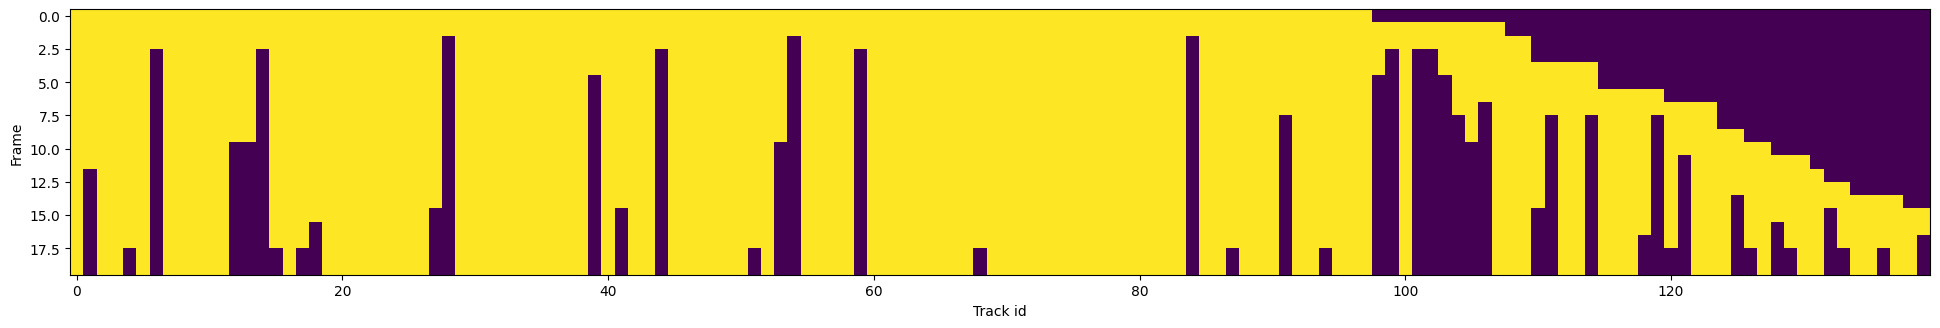

In [10]:
def display_lifetime(tracks):
    # Transform into tensor
    tracks_tensor = byotrack.Track.tensorize(tracks)
    print(tracks_tensor.shape)  # N_frame x N_track x D

    mask = ~ torch.isnan(tracks_tensor).any(dim=2)

    plt.figure(figsize=(24, 16), dpi=100)
    plt.xlabel("Track id")
    plt.ylabel("Frame")
    plt.imshow(mask)
    plt.show()
    
display_lifetime(tracklets)

In [11]:
def visualize_tracks(tracks, frame_id=0, fps=20, detections_sequence=()):
    """Interactive visualization
    
    CMDS:
        space: run/pause the video
        x/w: Move forward/backward in time
        c: Display detections
    """
    running = False
    display_detections = False

    while True:
        frame_id += running
        frame = (video[frame_id] * 255).astype(np.uint8)
        if display_detections and frame_id < len(detections_sequence):
            mask = (detections_sequence[frame_id].segmentation.numpy() != 0).astype(np.uint8) * 255
            frame = np.concatenate((mask[..., None], frame, np.zeros_like(frame)), axis=2)
        else:
            frame = np.concatenate((np.zeros_like(frame), frame, np.zeros_like(frame)), axis=2)

        # Add tracklets
        for track in tracks:
            point = track[frame_id]
            if torch.isnan(point).any():
                continue

            i, j = point.round().to(torch.int).tolist()

            color = (0, 0, 255)  # Red

            cv2.circle(frame, (j, i), 5, color)
            cv2.putText(frame, str(track.identifier % 100), (j + 4, i - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color)

        # Display the resulting frame
        cv2.imshow('Frame', frame)
        cv2.setWindowTitle('Frame', f'Frame {frame_id} / {len(video)}')

        # Press Q on keyboard to  exit
        key = cv2.waitKey(1000 // fps) & 0xFF

        if key == ord('q'):
            break

        if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
            break

        if key == ord(" "):
            running = not running

        if not running and key == ord("w"):  # Prev
            frame_id = (frame_id - 1) % len(video)

        if not running and key == ord("x"):  # Next
            frame_id = (frame_id + 1) % len(video)

        if key == ord("c"):
            display_detections = 1 - display_detections

    # Closes all the frames
    cv2.destroyAllWindows()
    
visualize_tracks(tracklets, detections_sequence=detections_sequence)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to target thread (0x55c844c80900)

QObject::moveToThread: Current thread (0x55c844c80900) is not the object's thread (0x55c8453a56d0).
Cannot move to tar

In [ ]:
# Refine tracks: Clean and stich

cleaner = Cleaner(min_length=5, max_dist=3.5)
tracks_clean = cleaner.run(video, tracklets)

stitcher = EMC2Stitcher(eta=5.0)  # Don't link tracks if they are too far (EMC dist > 5 (pixels))
tracks_stitched = stitcher.run(video, tracks_clean)

In [ ]:
display_lifetime(tracks_stitched)

In [ ]:
visualize_tracks(tracks_stitched, detections_sequence=detections_sequence)

In [ ]:
# Filter tracks and interpolate

# keep only big enough tracks (Cover at least 80% of video from start to end)
valid_tracks = [len(t) > 0.80 * len(video) for t in tracks_stitched]

interpolater = ForwardBackwardInterpolater(method="tps", full = True, alpha=10.0)
final_tracks = interpolater.run(video, tracks_stitched)  # Interpolate using all tracks, and filter afterwards
final_tracks = [track for i, track in enumerate(final_tracks) if valid_tracks[i]]

In [ ]:
visualize_tracks(final_tracks, detections_sequence=detections_sequence)

In [ ]:
byotrack.Track.save(final_tracks, "tracks.pt")